In [1]:
import os
import torch
from torchvision import datasets, transforms

data_dir = "/kaggle/input/new-data/new_dataset"
commercial_dir = os.path.join(data_dir, "commercial")
non_commercial_dir = os.path.join(data_dir, "non_commercial")

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(data_dir, transform=transform)

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])


In [2]:
import torch
import torch.nn as nn
from torchvision import models


class CustomMobileNet(nn.Module):
    def __init__(self):
        super(CustomMobileNet, self).__init__()

        
        model = models.mobilenet_v2(pretrained=True)

        
        for param in model.features[15:].parameters():
            param.requires_grad = False

        
        self.features = model.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Add new layers, including a Conv2d layer
        self.conv2d = nn.Conv2d(1280, 1024, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.conv2d(x)
        x = self.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the custom MobileNet model
custom_mobilenet = CustomMobileNet()



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 165MB/s]


In [3]:
import torch.optim as optim
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_mobilenet.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(custom_mobilenet.parameters(), lr=0.001, momentum=0.9)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    # Training loop
    custom_mobilenet.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = custom_mobilenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    # Validation loop
    custom_mobilenet.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = custom_mobilenet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Val Accuracy: {val_accuracies[-1]}")


Epoch 1/10, Train Loss: 0.690451443195343, Val Loss: 0.6851314455270767, Train Accuracy: 58.54271356783919, Val Accuracy: 70.9251101321586
Epoch 2/10, Train Loss: 0.6780689716339111, Val Loss: 0.6715354099869728, Train Accuracy: 66.33165829145729, Val Accuracy: 73.568281938326
Epoch 3/10, Train Loss: 0.6600072598457336, Val Loss: 0.6520876958966255, Train Accuracy: 81.4070351758794, Val Accuracy: 81.49779735682819
Epoch 4/10, Train Loss: 0.6322784042358398, Val Loss: 0.6181470528244972, Train Accuracy: 81.15577889447236, Val Accuracy: 82.81938325991189
Epoch 5/10, Train Loss: 0.5871384239196777, Val Loss: 0.5637113898992538, Train Accuracy: 84.2964824120603, Val Accuracy: 85.90308370044053
Epoch 6/10, Train Loss: 0.5148827981948852, Val Loss: 0.4809294231235981, Train Accuracy: 86.68341708542714, Val Accuracy: 86.34361233480176
Epoch 7/10, Train Loss: 0.42145524501800535, Val Loss: 0.39765696600079536, Train Accuracy: 88.69346733668341, Val Accuracy: 86.78414096916299
Epoch 8/10, Train

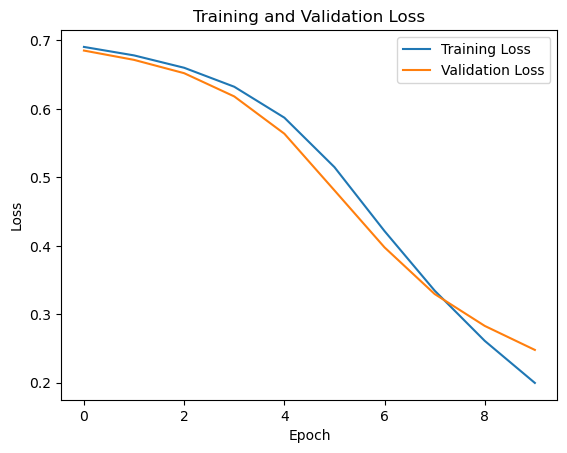

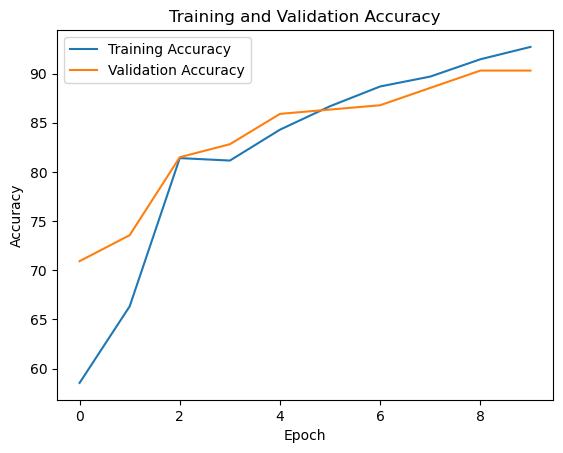

In [4]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [5]:
from sklearn.metrics import precision_recall_fscore_support

custom_mobilenet.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = custom_mobilenet(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Precision: 0.9245
Recall: 0.7903
F1 Score: 0.8522


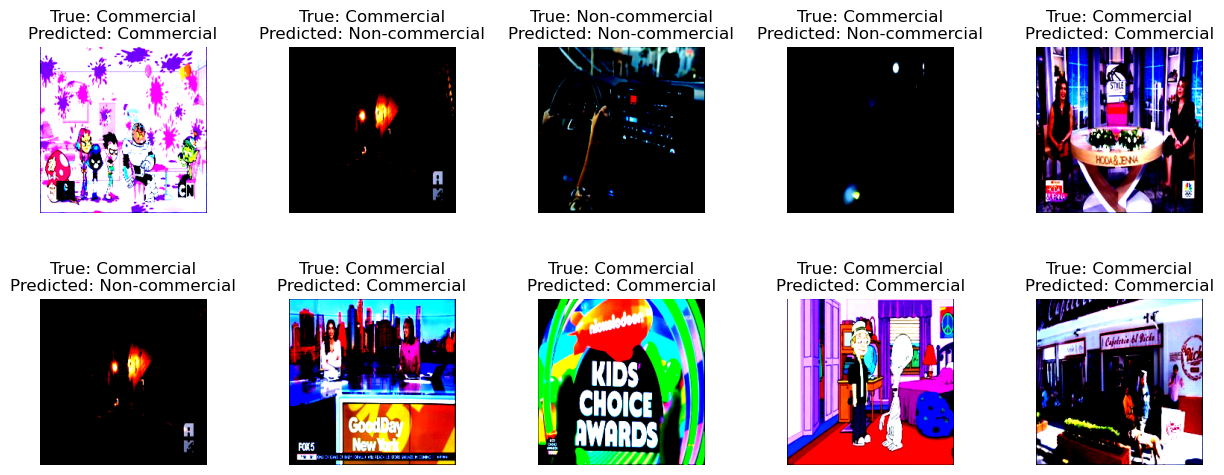

In [6]:
import random
import matplotlib.pyplot as plt


random_indices = random.sample(range(len(test_data)), 10)

# Visualize the frames with their true and predicted labels
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    image, label = test_data[idx]
    image_tensor = image.unsqueeze(0).to(device)
    output = custom_mobilenet(image_tensor)
    _, predicted = torch.max(output.data, 1)
    predicted_label = 'Commercial' if predicted.item() == 1 else 'Non-commercial'
    true_label = 'Commercial' if label == 1 else 'Non-commercial'

    axes[i].imshow(image.permute(1, 2, 0).numpy())
    axes[i].set_title(f"True: {true_label}\nPredicted: {predicted_label}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)
plt.show()
